# For a single HBL tile, plot a year of Fmask

In [1]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Visualization/Utilities')
import PreProcess_Utils as pputil
import Viz_Utils as vutil

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52202,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52260,Total threads: 10
Dashboard: http://127.0.0.1:52273/status,Memory: 0 B
Nanny: tcp://127.0.0.1:52205,


2025-03-25 12:01:01,317 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,329 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,337 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,344 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,352 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,362 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,371 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,378 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,385 - distributed.nanny - WARNING - Restarting worker
2025-03-25 12:01:01,393 - distributed.nanny - WARNING - Restarting worker


## Winter Year (2 years)

In [3]:
# Calculated from IMS (4 SnowDynamics_IMS)
sstart_first = 248
send_last = 166
smin_avg = 205

In [4]:
implausible_snow = [send_last + 7, sstart_first - 7]
implausible_snow 

[173, 241]

In [5]:
w_s = 2019 # Year that winter ends
w_e = 2020 # Year that winter starts

path = r'C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\1 HLS Fmask from STAC\fmask_nc'

In [6]:
%%time

# Individual yearly cubes
c_s = pputil.uploadNC(path + '/fmask_AlaskaSite_' + str(w_s) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_e = pputil.uploadNC(path + '/fmask_AlaskaSite_' + str(w_e) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})

# Combine same day, different sensor observations
c_s = c_s.groupby('time').min(engine = 'flox', skipna = True).squeeze()
c_e = c_e.groupby('time').min(engine = 'flox', skipna = True).squeeze()

fmask = xr.concat((c_s, c_e), dim = 'time').sortby('time') 

fmask = pputil.timestepClean(fmask, fmask.isin([1,2,3,4,5,6]), timestepClean = 'unclear', valid_status = 'static', invalid = 0, thresh = 99, 
                             verbose = False)
fmask

CPU times: total: 3.14 s
Wall time: 13 s


<xarray.DataArray 'stackstac-1507a70853706d14c932e732664c66c9' (time: 223,
                                                                y: 2436, x: 1581)> Size: 859MB
dask.array<getitem, shape=(223, 2436, 1581), dtype=uint8, chunksize=(1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
    band     <U5 20B 'Fmask'
  * x        (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y        (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
  * time     (time) datetime64[ns] 2kB 2019-03-02 2019-03-04 ... 2020-10-10
Attributes:
    spec:        RasterSpec(epsg=32606, bounds=(399510, 7606260, 446940, 7679...
    crs:         epsg:32606
    transform:   [ 3.00000e+01  0.00000e+00  3.99510e+05  0.00000e+00 -3.0000...
    resolution:  30

In [16]:
#c_e.constellation.values

In [8]:
fmask_sm = fmask[:, 2000-100:2000+100, 1150-100:1150+100]
fmask_sm

<xarray.DataArray 'stackstac-1507a70853706d14c932e732664c66c9' (time: 223,
                                                                y: 200, x: 200)> Size: 9MB
dask.array<getitem, shape=(223, 200, 200), dtype=uint8, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    band     <U5 20B 'Fmask'
  * x        (x) float64 2kB 4.31e+05 4.311e+05 4.311e+05 ... 4.37e+05 4.37e+05
  * y        (y) float64 2kB 7.622e+06 7.622e+06 ... 7.616e+06 7.616e+06
  * time     (time) datetime64[ns] 2kB 2019-03-02 2019-03-04 ... 2020-10-10
Attributes:
    spec:        RasterSpec(epsg=32606, bounds=(399510, 7606260, 446940, 7679...
    crs:         epsg:32606
    transform:   [ 3.00000e+01  0.00000e+00  3.99510e+05  0.00000e+00 -3.0000...
    resolution:  30

# Visualize Fmask time-series
- May take a couple minutes

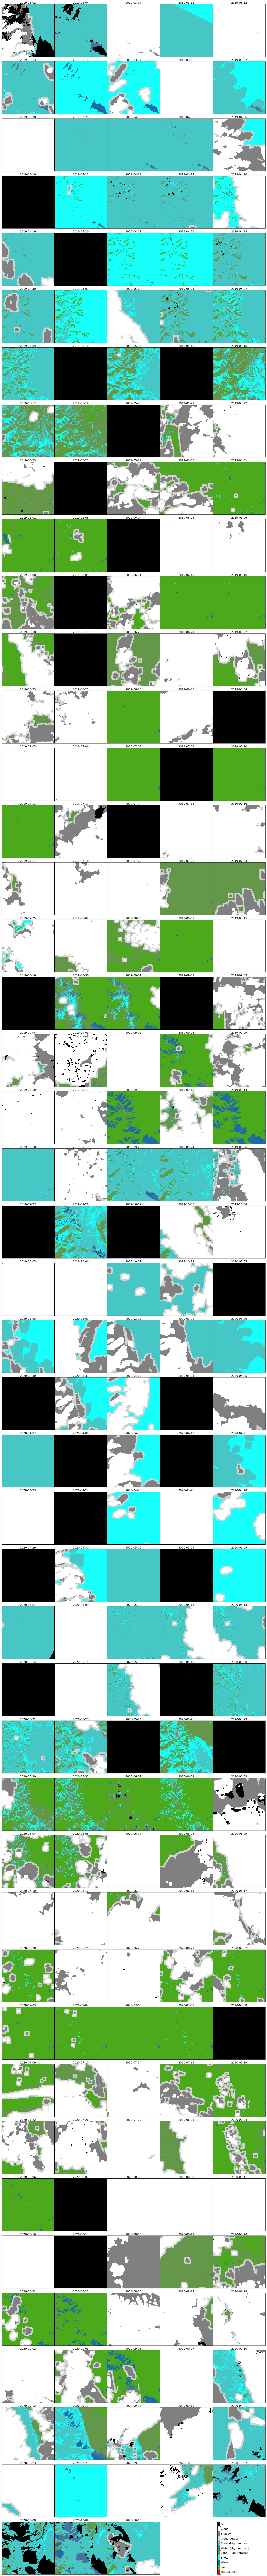

In [9]:
vutil.matrixPlot(fmask_sm, form = 'Fmask', sat = 'hls', byCon = False) # Full extent, all time-steps # fmask
#vutil.matrixPlot(fmask[40:53, :, :], form = 'Fmask', sat = 'hls', byCon = False)

#vutil.matrixPlot(fmask[100:, :, :], type = 'Fmask', sat = 'hls', byCon = False) # Just some timesteps
# Looking for May 5 to June 9 (40:53)
#vutil.matrixPlot(fmask[40:54, :, :], form = 'Fmask', sat = 'hls', byCon = False, save = 'Figure 4.tif') 

#vutil.matrixPlot(fmask[:, :, 511-60:511+60, 675-60:675+60], type = 'Fmask', sat = 'hls', byCon = False) # 10 x 10 around location of interest

In [58]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# #cube1 = fmask.copy()

In [57]:
# colors = ['#FF0000', '#4DA91C', '#1C6BA9', '#17FFFB', '#649749', '#497497', '#46c6c4', '#d3d3d3', '#808080', '#FFFFFF', '#000000']
# scale = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]

# cmap = mpl.colors.ListedColormap(colors)
# norm = mpl.colors.BoundaryNorm(scale, len(colors))

# plot = fmask[40:54, :, :].squeeze().plot.imshow(col = 'time', col_wrap = 5, size = 3.5 / 2.175, cmap = cmap, norm = norm, add_colorbar = False) # figsize = (6.5, 5)

# plt.tight_layout(h_pad = -0.75, w_pad = -14) # h_pad = 0.25, w_pad = -12.5

# cb = plt.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = cmap), ax = plot.axs[-1,-1], anchor = (-4.4, 0.5), ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# cb.ax.tick_params(size = 0, labelsize = 8)
# cb.ax.set_yticklabels(['Outside ROI', 'Land', 'Water', 'Snow', 'Land (High Aerosol)', 'Water (High Aerosol)', 'Snow (High Aerosol)', 'Cloud-adjacent', 'Shadow', 'Cloud', 'Fill'])

# for i, ax in enumerate(plot.axs.flat):
#     ax.set_yticks([]) # Remove y axis ticks
#     ax.set_xticks([]) # Remove x axis ticks
#     ax.set_ylabel('') # Remove y axis labels
#     ax.set_xlabel('') # Remove x axis labels
#     ax.set_aspect('equal') # Force square pixels
#     ax.set_title(ax.title.get_text()[7:], fontsize = 8, pad = 1) # Remotes 'time = ' 

# plt.show()

# plot.fig.get_figure().savefig('Figure 4_1.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})

In [33]:
# for i, ax in enumerate(plot.axs.flat):
#     print(ax)

In [ ]:
# After lunch, apply this to Viz_Utils and make plot